# Marathi Movie Review Sentiment Classification using a SentiWordNet-Derived Lexicon

This notebook demonstrates a transparent lexicon-based approach to sentiment analysis for Marathi **movie reviews** (L3Cube MahaSent MR dataset). Instead of tweets, we process full/partial review sentences from `L3Cube_MahaSent_MR/MahaSent_MR_Train.csv`. We leverage a custom Marathi sentiment lexicon generated from SentiWordNet alignment / prior processing (`marathi_word_sentiments.csv`).

Workflow:
1. Load sentiment lexicon mapping Marathi words to sentiment labels (+, -, neutral).
2. Load labeled movie review sentences (gold labels: positive, negative, neutral variants).
3. Clean & tokenize Devanagari text.
4. Match tokens to lexicon entries; collect per-token sentiment polarity.
5. Aggregate token sentiments to a sentence-level label via majority & weighted strategies.
6. Evaluate: accuracy, precision, recall, F1, confusion matrix, per-class metrics.
7. Visualize lexicon distributions with word clouds.
8. Perform error analysis and save predictions.

Limitations: No explicit handling of negation, sarcasm, intensifiers, or multi-word expressions yet. These can be layered atop this baseline.

---

### Using Strict Balanced Combined Dataset
We now integrate the strictly domain-balanced (Movie Reviews vs Subtitles/Tweets) sentiment data produced in `marathi_sentiment_swn_pipeline.ipynb`.

Files expected (if strict balancing cell was run there):
- `output/combined_dataset/train_strict.csv`
- `output/combined_dataset/val_strict.csv`
- `output/combined_dataset/test_strict.csv`

Fallback logic (simple):
1. Try strict split files.
2. Else try `output/combined_dataset/balanced_mode_strict.csv`.
3. Else fallback to earlier `output/combined_marathi_dataset.csv`.

We keep code simple (no complex abstractions) and map any numeric labels (-1,0,1) to text labels (negative, neutral, positive) for consistency with lexicon evaluation.

Set `USE_STRICT = True` to prefer strict balanced splits; set to `False` to just use the full combined dataset.

In [30]:
# Load balanced or fallback dataset (simple approach)
import pandas as pd
from pathlib import Path

USE_STRICT = True

base_dir = Path('output/combined_dataset')
strict_train = base_dir / 'train_strict.csv'
strict_val = base_dir / 'val_strict.csv'
strict_test = base_dir / 'test_strict.csv'
strict_full = base_dir / 'balanced_mode_strict.csv'
legacy_full = Path('output/combined_marathi_dataset.csv')

label_map_numeric = {'-1':'negative','0':'neutral','1':'positive'}

def load_one(p):
    if p.exists():
        df = pd.read_csv(p)
        if 'label' in df.columns:
            df['label'] = df['label'].astype(str).map(label_map_numeric).fillna(df['label'])
        return df
    return None

if USE_STRICT and strict_train.exists() and strict_val.exists() and strict_test.exists():
    train_df = load_one(strict_train)
    val_df = load_one(strict_val)
    test_df = load_one(strict_test)
    source_mode = 'strict splits'
elif USE_STRICT and strict_full.exists():
    full_df = load_one(strict_full)
    # simple manual split 70/15/15 without strat because strict already balanced
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = len(full_df)
    n_train = int(0.7*n)
    n_val = int(0.85*n)
    train_df = full_df.iloc[:n_train].copy()
    val_df = full_df.iloc[n_train:n_val].copy()
    test_df = full_df.iloc[n_val:].copy()
    source_mode = 'strict full -> manual split'
elif legacy_full.exists():
    full_df = load_one(legacy_full)
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = len(full_df)
    n_train = int(0.7*n)
    n_val = int(0.85*n)
    train_df = full_df.iloc[:n_train].copy()
    val_df = full_df.iloc[n_train:n_val].copy()
    test_df = full_df.iloc[n_val:].copy()
    source_mode = 'legacy combined dataset'
else:
    raise FileNotFoundError('No balanced or combined dataset files found. Run the pipeline notebook first.')

for name, df in [('train',train_df),('val',val_df),('test',test_df)]:
    missing = df['label'].isna().sum() if 'label' in df.columns else 'NA'
    print(f"{name}: rows={len(df)} missing_labels={missing}")
print('Loaded dataset source mode:', source_mode)

# Provide a unified 'text' column name for later steps
if 'text' not in train_df.columns:
    # heuristic fallback if column differs
    for c in train_df.columns:
        if 'text' in c.lower() or 'sentence' in c.lower():
            train_df.rename(columns={c:'text'}, inplace=True)
            val_df.rename(columns={c:'text'}, inplace=True, errors='ignore')
            test_df.rename(columns={c:'text'}, inplace=True, errors='ignore')
            break

train_df.head()

train: rows=21000 missing_labels=0
val: rows=4500 missing_labels=0
test: rows=4500 missing_labels=0
Loaded dataset source mode: legacy combined dataset


,text,label_raw,label,source
0,भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...,-1,negative,MR
1,या लोकांना पहा?,0,neutral,MS
2,"ठीक आहे, माझ्याकडे एक वेडी आहे.",0,neutral,MS
3,आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता.,1,positive,MS
4,तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...,-1,negative,MR


In [31]:
# Section 1: Imports & Configuration
import pandas as pd
import numpy as np
import re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# File paths (adjust if your filenames differ)
LEXICON_FILE = Path('marathi_word_sentiments.csv')  # produced earlier: columns marathi_word, sentiment_label (positive, negative, neutral or symbolic)
REVIEWS_FILE = Path('output')/'combined_marathi_dataset.csv'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Devanagari regex for token extraction
DEVANAGARI_REGEX = re.compile(r'[\u0900-\u097F]+')

# Standardized label set
LABEL_CANONICAL = ['positive','negative','neutral']

# Label to numeric mapping (positive=1, negative=-1, neutral=0)
LABEL_TO_NUM = {'positive': 1, 'negative': -1, 'neutral': 0}
NUM_TO_LABEL = {v: k for k, v in LABEL_TO_NUM.items()}

print('Lexicon file exists:', LEXICON_FILE.exists())
print('Reviews file exists:', REVIEWS_FILE.exists())

Lexicon file exists: True
Reviews file exists: True


In [32]:
# Section 2: Load Lexicon & Dataset (Flexible, Reusing Balanced Splits If Present)
import pandas as pd

lex_cols = ['marathi_word', 'sentiment_label']
lexicon = pd.read_csv(LEXICON_FILE)
missing_lex_cols = [c for c in lex_cols if c not in lexicon.columns]
if missing_lex_cols:
    raise ValueError(f'Missing required lexicon columns: {missing_lex_cols}')

# Mapping symbols/variants to canonical textual labels
symbol_to_word = {
    '+': 'positive', 'pos': 'positive', 'positive': 'positive', '1': 'positive', '1.0': 'positive', 'positive_tweet': 'positive',
    '-': 'negative', 'neg': 'negative', 'negative': 'negative', '-1': 'negative', '-1.0': 'negative', 'negative_tweet': 'negative',
    '0': 'neutral', 'neu': 'neutral', 'neutral': 'neutral'
}

# Clean lexicon
lexicon['marathi_word'] = lexicon['marathi_word'].astype(str).str.strip().str.lower()
lexicon['sentiment_label'] = (lexicon['sentiment_label']
                              .astype(str).str.strip().str.lower()
                              .map(symbol_to_word))
lexicon['sentiment_label'] = lexicon['sentiment_label'].fillna('neutral')
lexicon.loc[~lexicon['sentiment_label'].isin(LABEL_CANONICAL), 'sentiment_label'] = 'neutral'
lexicon['sentiment_numeric'] = lexicon['sentiment_label'].map(LABEL_TO_NUM)
lexicon = lexicon.drop_duplicates(subset=['marathi_word'])
print('Lexicon shape:', lexicon.shape)

# ------------ DATASET LOADING (FLEXIBLE) -------------
# Prefer already loaded balanced splits (train_df / val_df / test_df) from earlier cell.
# Fallback to legacy single combined file if splits not present.

use_balanced_splits = all(name in globals() for name in ['train_df','val_df','test_df']) and \
    all(isinstance(globals()[name], pd.DataFrame) for name in ['train_df','val_df','test_df'])

if use_balanced_splits:
    parts = []
    for split_name, df_part in [('train', train_df), ('val', val_df), ('test', test_df)]:
        if df_part is not None and len(df_part):
            p = df_part.copy()
            p['split'] = split_name
            parts.append(p)
    if not parts:
        raise ValueError('Balanced splits detected but empty. Regenerate in pipeline notebook.')
    reviews_raw = pd.concat(parts, ignore_index=True)
    data_source_mode = 'balanced_strict_splits'
else:
    if not REVIEWS_FILE.exists():
        raise FileNotFoundError('No balanced splits in memory and legacy file not found. Run pipeline notebook first.')
    reviews_raw = pd.read_csv(REVIEWS_FILE)
    data_source_mode = 'legacy_combined_file'

print(f'Dataset load mode: {data_source_mode}; rows={len(reviews_raw)} columns={list(reviews_raw.columns)}')

# Remove unnamed cols
unnamed_cols = [c for c in reviews_raw.columns if c.lower().startswith('unnamed')]
if unnamed_cols:
    reviews_raw = reviews_raw.drop(columns=unnamed_cols)

# Identify candidate text column
text_col_candidates = ['text','marathi_sentence','sentence','review','comment']
found_text_col = None
for cand in text_col_candidates:
    for col in reviews_raw.columns:
        if col.lower() == cand.lower():
            found_text_col = col
            break
    if found_text_col:
        break
if not found_text_col:
    # heuristic: longest string columns maybe
    object_cols = [c for c in reviews_raw.columns if reviews_raw[c].dtype == 'object']
    if object_cols:
        found_text_col = object_cols[0]
    else:
        raise ValueError('Could not infer a text column in dataset.')

# Identify label column
label_col_candidates = ['gold_label','label','sentiment','target','y']
found_label_col = None
for cand in label_col_candidates:
    for col in reviews_raw.columns:
        if col.lower() == cand.lower():
            found_label_col = col
            break
    if found_label_col:
        break
if not found_label_col:
    raise ValueError('Could not find any label column among: ' + ', '.join(label_col_candidates))

reviews = reviews_raw[[found_text_col, found_label_col]].rename(columns={found_text_col:'text', found_label_col:'label'}).copy()

# Drop missing text
reviews = reviews.dropna(subset=['text']).reset_index(drop=True)

# Normalize gold labels (map any numeric/string variants)
reviews['gold_label'] = (reviews['label']
                         .astype(str).str.strip().str.lower()
                         .map(symbol_to_word).fillna('neutral'))

# Basic diagnostics
print('Reviews shape after selection:', reviews.shape)
print('Label distribution:', reviews['gold_label'].value_counts(dropna=False).to_dict())
print('Sample rows:')
print(reviews.head(5))

Lexicon shape: (38212, 9)
Dataset load mode: balanced_strict_splits; rows=30000 columns=['text', 'label_raw', 'label', 'source', 'split']
Reviews shape after selection: (30000, 3)
Label distribution: {'negative': 10000, 'neutral': 10000, 'positive': 10000}
Sample rows:
                                                text     label gold_label
0  भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...  negative   negative
1                                    या लोकांना पहा?   neutral    neutral
2                    ठीक आहे, माझ्याकडे एक वेडी आहे.   neutral    neutral
3   आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता.  positive   positive
4  तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...  negative   negative


In [33]:
# Section 3: Quick Data Inspection
print('Gold label distribution (reviews):')
print(reviews['gold_label'].value_counts(dropna=False))

print('\nLexicon label distribution:')
print(lexicon['sentiment_label'].value_counts())

print('\nSample lexicon entries:')
print(lexicon.head())

print('\nUnique lexicon words:', lexicon['marathi_word'].nunique())
print('Sample review sentences:')
print(reviews['text'].head())

Gold label distribution (reviews):
gold_label
negative    10000
neutral     10000
positive    10000
Name: count, dtype: int64

Lexicon label distribution:
sentiment_label
neutral     27879
positive     5241
negative     5092
Name: count, dtype: int64

Sample lexicon entries:
  marathi_word sentiment_label  pos_score  neg_score  obj_score  \
0       अजन्मा         neutral      0.000    0.00000    0.00000   
1         अशुभ        negative      0.125    0.75000    0.12500   
2        अमंगळ         neutral      0.000    0.00000    0.00000   
3    अप्रविष्ट         neutral      0.000    0.00000    1.00000   
4    पुण्यभूमी        positive      0.625    0.15625    0.21875   

  english_translation  synset_id        pos  sentiment_numeric  
0  indiscriminateness        101  adjective                  0  
1             ominous        101  adjective                 -1  
2         unpreigning        101  adjective                  0  
3       unprecedented        111  adjective                  

In [34]:
# Section 4: Preprocessing Functions (Cleaning & Tokenization)
PUNCT_PATTERN = re.compile(r"[\"'!?,.;:()\[\]{}<>#@/\\|*^%$~`+=\-]")

def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ''
    t = t.strip()
    t = re.sub(r'https?://\S+', ' ', t)  # URLs
    t = re.sub(r'[@#]', ' ', t)           # mentions/hashtags symbols
    t = re.sub(r'\d+', ' ', t)           # digits (optional)
    t = PUNCT_PATTERN.sub(' ', t)         # punctuation
    t = re.sub(r'\s+', ' ', t)
    return t.strip()

def tokenize_marathi(t: str):
    if not t:
        return []
    tokens = DEVANAGARI_REGEX.findall(t)
    if not tokens:
        tokens = t.split()
    tokens = [tok.strip().lower() for tok in tokens if tok.strip()]
    return tokens

def preprocess_and_tokenize(df: pd.DataFrame, text_col: str) -> pd.DataFrame:
    df = df.copy()
    df['clean_text'] = df[text_col].apply(clean_text)
    df['tokens'] = df['clean_text'].apply(tokenize_marathi)
    df['unique_tokens'] = df['tokens'].apply(lambda lst: list(dict.fromkeys(lst)))
    return df

reviews = preprocess_and_tokenize(reviews, 'text')
print(reviews[['text','clean_text','tokens']].head())
print('Average tokens per review sentence:', np.mean(reviews['tokens'].apply(len)))

                                                text  \
0  भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...   
1                                    या लोकांना पहा?   
2                    ठीक आहे, माझ्याकडे एक वेडी आहे.   
3   आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता.   
4  तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...   

                                          clean_text  \
0  भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...   
1                                     या लोकांना पहा   
2                      ठीक आहे माझ्याकडे एक वेडी आहे   
3    आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता   
4  तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...   

                                              tokens  
0  [भारत, देशात, पाकिस्तानी, अतिरेक्यांनी, त्यांच...  
1                                 [या, लोकांना, पहा]  
2               [ठीक, आहे, माझ्याकडे, एक, वेडी, आहे]  
3  [आपल्याला, आपले, पैसे, मिळतात, आणि, आपण, काहीत...  
4  [तसेच, सिनेमातील, काही, प्रश्नांची, उत्तरं, मा..

In [35]:
# Section 5: Apply Lexicon (Token Sentiment Mapping)
lexicon_map = dict(zip(lexicon['marathi_word'], lexicon['sentiment_numeric']))

matched_counts = []
unmatched_counts = []
token_sentiments_list = []
matched_tokens_store = []

for toks in reviews['unique_tokens']:
    sentiments = []
    matched_tokens = []
    for tok in toks:
        if tok in lexicon_map:
            val = lexicon_map[tok]
            sentiments.append(val)
            matched_tokens.append(tok)
    unmatched = len(toks) - len(sentiments)
    matched_counts.append(len(sentiments))
    unmatched_counts.append(unmatched)
    token_sentiments_list.append(sentiments)
    matched_tokens_store.append(matched_tokens)

reviews['token_sentiments'] = token_sentiments_list
reviews['matched_tokens'] = matched_tokens_store
reviews['matched_tokens_count'] = matched_counts
reviews['unmatched_tokens_count'] = unmatched_counts

print(reviews[['tokens','matched_tokens','token_sentiments']].head())
print('Overall coverage (reviews with >=1 matched token):', (reviews['matched_tokens_count']>0).mean())

                                              tokens  \
0  [भारत, देशात, पाकिस्तानी, अतिरेक्यांनी, त्यांच...   
1                                 [या, लोकांना, पहा]   
2               [ठीक, आहे, माझ्याकडे, एक, वेडी, आहे]   
3  [आपल्याला, आपले, पैसे, मिळतात, आणि, आपण, काहीत...   
4  [तसेच, सिनेमातील, काही, प्रश्नांची, उत्तरं, मा...   

                    matched_tokens token_sentiments  
0  [भारत, पाकिस्तानी, स्लीपर, सेल]     [0, 0, 0, 0]  
1                               []               []  
2                  [ठीक, एक, वेडी]       [1, 1, -1]  
3                               []               []  
4                [काही, अनुत्तरित]           [0, 0]  
Overall coverage (reviews with >=1 matched token): 0.9200666666666667


In [36]:
# Section 6: Aggregation Strategies (Majority vs Weighted)
from collections import Counter as Cntr

def majority_vote(scores):
    # scores: list of numeric sentiments in {-1,0,1}
    if not scores:
        return 0
    # Remove zeros for polarity decision; if all zero -> neutral
    nonzero = [s for s in scores if s != 0]
    if not nonzero:
        return 0
    counts = Cntr(nonzero)
    # If tie, fallback to 0
    top = counts.most_common()
    if len(top) > 1 and top[0][1] == top[1][1]:
        return 0
    return top[0][0]

def weighted_sum(scores, margin=0.0):
    if not scores:
        return 0
    s = sum(scores)
    if abs(s) <= margin:
        return 0
    return 1 if s > 0 else -1

def numeric_to_label(v):
    return NUM_TO_LABEL.get(v, 'neutral')

# Quick tests
print('Majority vote tests:', majority_vote([1,1,-1]), majority_vote([-1,-1,1]), majority_vote([0,0,0]))
print('Weighted sum tests:', weighted_sum([1,1,-1]), weighted_sum([-1,-1,1]), weighted_sum([0,0,0]))

Majority vote tests: 1 -1 0
Weighted sum tests: 1 -1 0


In [37]:
# Section 7: Predict Review Sentiments (Add Numeric Outputs + Idempotent Helper)
# We wrap the original logic in a helper so later cells can (re)generate predictions
# safely if a user re-runs cells out of order.

def ensure_review_predictions(reviews_df):
    required_cols = ['token_sentiments', 'matched_tokens_count', 'unmatched_tokens_count']
    for rc in required_cols:
        if rc not in reviews_df.columns:
            raise ValueError(f"Column '{rc}' missing. Run preprocessing & lexicon mapping sections first (Sections 4-5).")
    # If predictions already exist, skip recomputation (idempotent behavior)
    pred_cols = ['predicted_label_majority','predicted_label_weighted',
                 'predicted_num_majority','predicted_num_weighted','gold_num','lexicon_coverage']
    if all(pc in reviews_df.columns for pc in pred_cols):
        return reviews_df

    majority_predictions = []
    weighted_predictions = []
    majority_predictions_num = []
    weighted_predictions_num = []

    margin = 0.0  # neutrality margin (tunable)

    for scores in reviews_df['token_sentiments']:
        maj_num = majority_vote(scores)
        wei_num = weighted_sum(scores, margin=margin)
        majority_predictions_num.append(maj_num)
        weighted_predictions_num.append(wei_num)
        majority_predictions.append(numeric_to_label(maj_num))
        weighted_predictions.append(numeric_to_label(wei_num))

    # Store symbolic labels
    reviews_df['predicted_label_majority'] = majority_predictions
    reviews_df['predicted_label_weighted'] = weighted_predictions

    # Store numeric predictions
    reviews_df['predicted_num_majority'] = majority_predictions_num
    reviews_df['predicted_num_weighted'] = weighted_predictions_num

    # Gold numeric label (map existing gold_label)
    if 'gold_label' not in reviews_df.columns:
        raise ValueError("'gold_label' missing – ensure label normalization earlier.")
    reviews_df['gold_num'] = reviews_df['gold_label'].map(LABEL_TO_NUM).fillna(0).astype(int)

    # Coverage metric
    reviews_df['lexicon_coverage'] = reviews_df.apply(
        lambda r: (r['matched_tokens_count'] / max(1, r['matched_tokens_count'] + r['unmatched_tokens_count'])), axis=1
    )
    return reviews_df

# Execute prediction generation (idempotent)
reviews = ensure_review_predictions(reviews)
print(reviews[['gold_label','gold_num','predicted_label_weighted','predicted_num_weighted','lexicon_coverage']].head())
print('Mean coverage:', reviews['lexicon_coverage'].mean())

  gold_label  gold_num predicted_label_weighted  predicted_num_weighted  \
0   negative        -1                  neutral                       0   
1    neutral         0                  neutral                       0   
2    neutral         0                 positive                       1   
3   positive         1                  neutral                       0   
4   negative        -1                  neutral                       0   

   lexicon_coverage  
0          0.444444  
1          0.000000  
2          0.600000  
3          0.000000  
4          0.250000  
Mean coverage: 0.3295183505138314


## Section 8: Evaluation Metrics (Accuracy, Precision, Recall, F1)
We use the weighted aggregation prediction for the core metrics on canonical sentiment classes: `positive`, `negative`, `neutral`. Definitions:

Accuracy = (Correct Predictions) / (Total Samples)  
Precision (per class) = TP / (TP + FP)  
Recall (per class) = TP / (TP + FN)  
F1 (per class) = 2 * (Precision * Recall) / (Precision + Recall)  

We report macro averages (simple mean across classes) and weighted averages (support-weighted across classes). All labels are textual (no symbolic + / -) in this updated version.

In [38]:
# Evaluation using weighted predictions on movie reviews (Canonical textual labels)
y_true_sym = reviews['gold_label']
y_pred_sym = reviews['predicted_label_weighted']
y_true_num = reviews['gold_num']
y_pred_num = reviews['predicted_num_weighted']

label_order = ['positive','negative','neutral']

acc_sym = accuracy_score(y_true_sym, y_pred_sym)
prec_macro_sym, rec_macro_sym, f1_macro_sym, _ = precision_recall_fscore_support(y_true_sym, y_pred_sym, average='macro', zero_division=0)
prec_w_sym, rec_w_sym, f1_w_sym, _ = precision_recall_fscore_support(y_true_sym, y_pred_sym, average='weighted', zero_division=0)

acc_num = accuracy_score(y_true_num, y_pred_num)
prec_macro_num, rec_macro_num, f1_macro_num, _ = precision_recall_fscore_support(y_true_num, y_pred_num, average='macro', zero_division=0)
prec_w_num, rec_w_num, f1_w_num, _ = precision_recall_fscore_support(y_true_num, y_pred_num, average='weighted', zero_division=0)

print('=== Text Label Metrics (positive, negative, neutral) ===')
print(f'Accuracy: {acc_sym:.4f}')
print(f'Macro Precision: {prec_macro_sym:.4f}  Macro Recall: {rec_macro_sym:.4f}  Macro F1: {f1_macro_sym:.4f}')
print(f'Weighted Precision: {prec_w_sym:.4f}  Weighted Recall: {rec_w_sym:.4f}  Weighted F1: {f1_w_sym:.4f}')

print('\n=== Numeric Label Metrics (-1,0,1 mapped to negative,neutral,positive respectively) ===')
print(f'Accuracy: {acc_num:.4f}')
print(f'Macro Precision: {prec_macro_num:.4f}  Macro Recall: {rec_macro_num:.4f}  Macro F1: {f1_macro_num:.4f}')
print(f'Weighted Precision: {prec_w_num:.4f}  Weighted Recall: {rec_w_num:.4f}  Weighted F1: {f1_w_num:.4f}')

per_class_sym = precision_recall_fscore_support(y_true_sym, y_pred_sym, labels=label_order, zero_division=0)
per_class_df = pd.DataFrame({
    'label': label_order,
    'precision': per_class_sym[0],
    'recall': per_class_sym[1],
    'f1': per_class_sym[2],
    'support': per_class_sym[3]
})
per_class_df

=== Text Label Metrics (positive, negative, neutral) ===
Accuracy: 0.4972
Macro Precision: 0.5098  Macro Recall: 0.4972  Macro F1: 0.4946
Weighted Precision: 0.5098  Weighted Recall: 0.4972  Weighted F1: 0.4946

=== Numeric Label Metrics (-1,0,1 mapped to negative,neutral,positive respectively) ===
Accuracy: 0.4972
Macro Precision: 0.5098  Macro Recall: 0.4972  Macro F1: 0.4946
Weighted Precision: 0.5098  Weighted Recall: 0.4972  Weighted F1: 0.4946


,label,precision,recall,f1,support
0,positive,0.525096,0.5869,0.554281,10000
1,negative,0.573574,0.3781,0.455762,10000
2,neutral,0.430627,0.5267,0.473843,10000


In [39]:
# NEW: Sample of predictions with numeric vs symbolic (robust to re-order execution)
needed_pred_cols = ['gold_num','predicted_label_weighted','predicted_num_weighted',
                    'predicted_label_majority','predicted_num_majority','lexicon_coverage','matched_tokens']
missing = [c for c in needed_pred_cols if c not in reviews.columns]
if missing:
    print('Some prediction columns missing, regenerating predictions:', missing)
    reviews = ensure_review_predictions(reviews)

present = [c for c in needed_pred_cols if c in reviews.columns]
sample_cols = ['text','gold_label'] + present
sample_display = reviews.head(12)[sample_cols]
sample_display

,text,gold_label,gold_num,predicted_label_weighted,predicted_num_weighted,predicted_label_majority,predicted_num_majority,lexicon_coverage,matched_tokens
0,भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...,negative,-1,neutral,0,neutral,0,0.444444,"[भारत, पाकिस्तानी, स्लीपर, सेल]"
1,या लोकांना पहा?,neutral,0,neutral,0,neutral,0,0.000000,[]
2,"ठीक आहे, माझ्याकडे एक वेडी आहे.",neutral,0,positive,1,positive,1,0.600000,"[ठीक, एक, वेडी]"
3,आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता.,positive,1,neutral,0,neutral,0,0.000000,[]
4,तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...,negative,-1,neutral,0,neutral,0,0.250000,"[काही, अनुत्तरित]"
5,मराठी चित्रपटांमध्ये अभिनय आणि विनोदाची परिपक्...,positive,1,positive,1,positive,1,0.466667,"[मराठी, अभिनय, परिपक्व, परिभाषा, अशोक, सराफ, ल..."
6,सुरुवातीला हे पैसे घेण्यास हिरा नकार देतो,neutral,0,neutral,0,neutral,0,0.285714,"[हिरा, नकार]"
7,त्याच्यासोबत दुबईला जायला मिळेल म्हणून लग्न कर...,neutral,0,positive,1,positive,1,0.333333,"[म्हणून, लग्न, भाग]"
8,"त्यामुळे केवळ कलाकार चित्रपट पुढे कसा नेतायेत,...",positive,1,positive,1,positive,1,0.545455,"[त्यामुळे, केवळ, कलाकार, पुढे, कसा, उत्सुकता]"
9,जर तुम्हाला वाटत असेल की मी तुम्हाला माझ्या मा...,negative,-1,neutral,0,neutral,0,0.133333,"[जर, तर]"


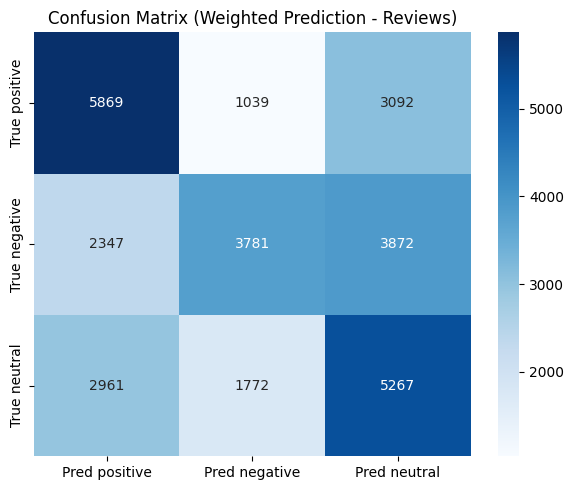

Classification Report (text labels):
              precision    recall  f1-score   support

    positive     0.5251    0.5869    0.5543     10000
    negative     0.5736    0.3781    0.4558     10000
     neutral     0.4306    0.5267    0.4738     10000

    accuracy                         0.4972     30000
   macro avg     0.5098    0.4972    0.4946     30000
weighted avg     0.5098    0.4972    0.4946     30000

              precision    recall  f1-score   support

    positive     0.5251    0.5869    0.5543     10000
    negative     0.5736    0.3781    0.4558     10000
     neutral     0.4306    0.5267    0.4738     10000

    accuracy                         0.4972     30000
   macro avg     0.5098    0.4972    0.4946     30000
weighted avg     0.5098    0.4972    0.4946     30000



In [40]:
# Section 9: Confusion Matrix & Classification Report (Movie Reviews - Canonical Labels)
labels_order = ['positive','negative','neutral']
cm = confusion_matrix(reviews['gold_label'], reviews['predicted_label_weighted'], labels=labels_order)
cm_df = pd.DataFrame(cm, index=[f'True {l}' for l in labels_order], columns=[f'Pred {l}' for l in labels_order])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Weighted Prediction - Reviews)')
plt.tight_layout()
plt.show()

print('Classification Report (text labels):')
print(classification_report(reviews['gold_label'], reviews['predicted_label_weighted'], labels=labels_order, digits=4, zero_division=0))

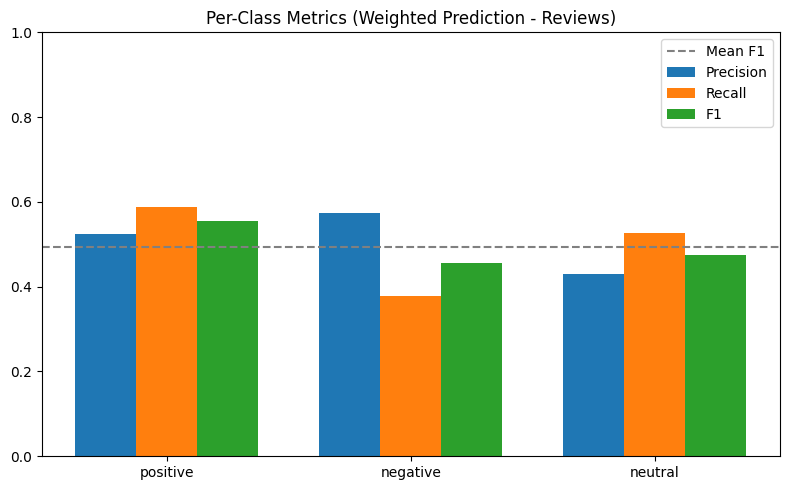

Review sentences with >=1 matched token coverage: 92.01%


In [41]:
# Section 10: Per-Class Metrics Visualization (Reviews)
plt.figure(figsize=(8,5))
bar_width = 0.25
x = np.arange(len(per_class_df))
plt.bar(x - bar_width, per_class_df['precision'], width=bar_width, label='Precision')
plt.bar(x, per_class_df['recall'], width=bar_width, label='Recall')
plt.bar(x + bar_width, per_class_df['f1'], width=bar_width, label='F1')
plt.xticks(x, per_class_df['label'])
plt.ylim(0,1)
plt.axhline(per_class_df['f1'].mean(), color='gray', linestyle='--', label='Mean F1')
plt.title('Per-Class Metrics (Weighted Prediction - Reviews)')
plt.legend()
plt.tight_layout()
plt.show()

coverage_prop = (reviews['matched_tokens_count']>0).mean()
print(f'Review sentences with >=1 matched token coverage: {coverage_prop:.2%}')

Counts -> positive: 5241  negative: 5092  neutral: 27879
Sample positive words: ['पुण्यभूमी', 'पुण्यस्थान', 'पवित्रस्थान', 'आगत', 'जल्मलेला', 'सत्कर्म', 'सुकृत', 'नैतिक_कार्य', 'शिष्टपणा', 'जुलूमजबरी']
Sample negative words: ['अशुभ', 'चारित्र्यहीनता', 'अत्याचार', 'जुलूम', 'घोटाळा', 'गोंधळ', 'गडबड', 'दुष्कर्म', 'खाद्यपदार्थ', 'कच्चा']


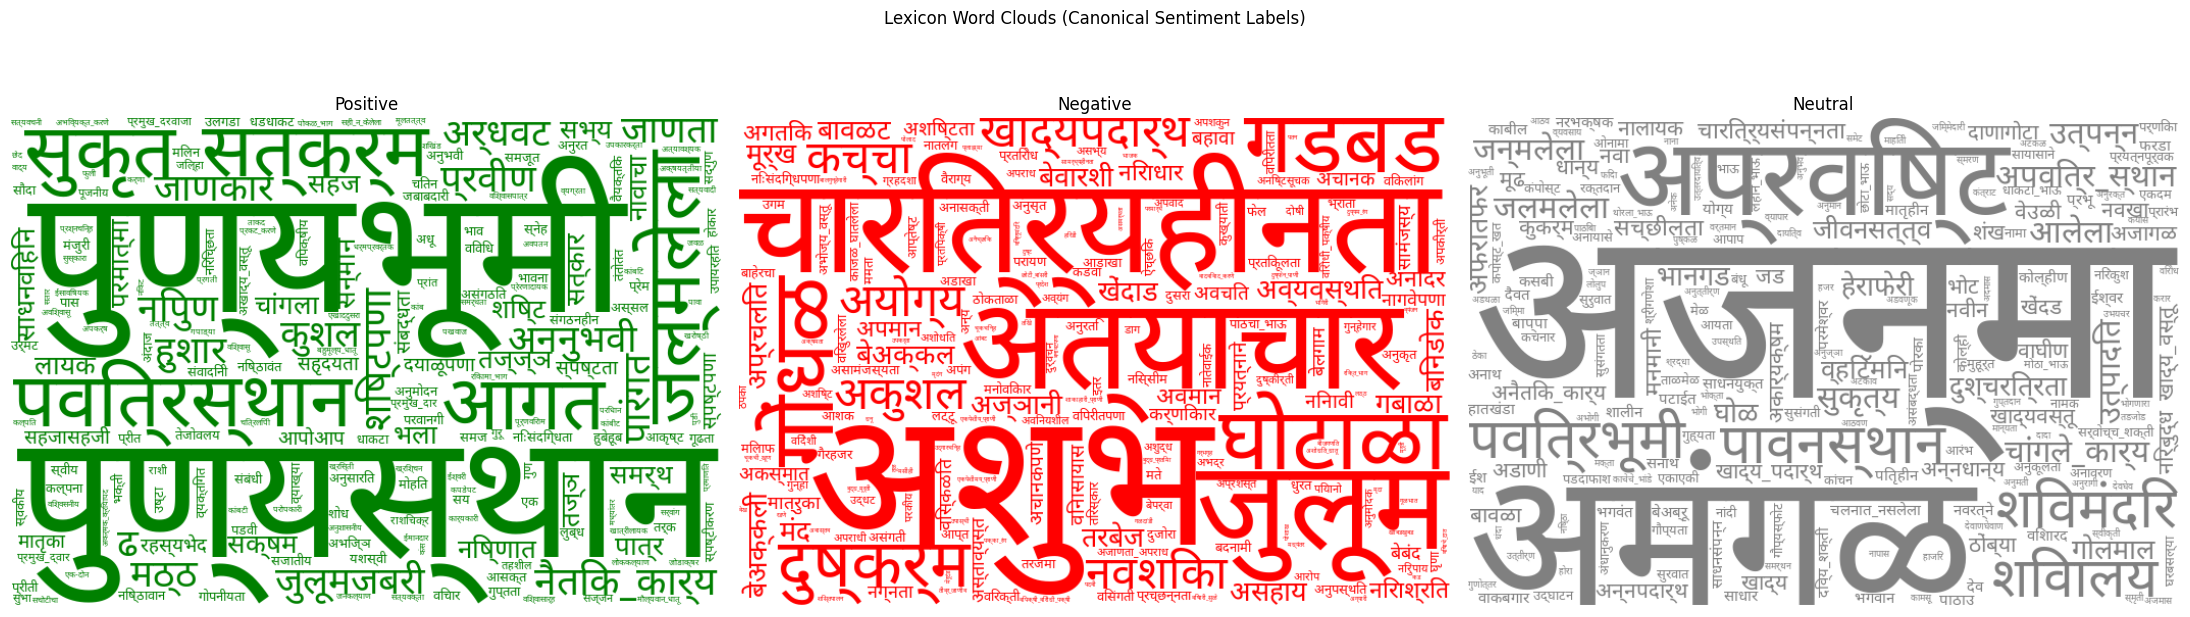

Top 15 positive words: ['पुण्यभूमी', 'पुण्यस्थान', 'पवित्रस्थान', 'आगत', 'जल्मलेला', 'सत्कर्म', 'सुकृत', 'नैतिक_कार्य', 'शिष्टपणा', 'जुलूमजबरी', 'अननुभवी', 'मठ्ठ', 'ढ', 'अर्धवट', 'प्रवीण']
Top 15 negative words: ['अशुभ', 'चारित्र्यहीनता', 'अत्याचार', 'जुलूम', 'घोटाळा', 'गोंधळ', 'गडबड', 'दुष्कर्म', 'खाद्यपदार्थ', 'कच्चा', 'अकुशल', 'अयोग्य', 'नवशिका', 'अव्यवस्थित', 'गबाळा']
Top 15 neutral words: ['अजन्मा', 'अमंगळ', 'अप्रविष्ट', 'पवित्रभूमी', 'पावनस्थान', 'शिवालय', 'शिवमंदिर', 'अपवित्र_स्थान', 'आलेला', 'जन्मलेला', 'जलमलेला', 'सुकृत्य', 'चांगले_कार्य', 'उत्पादित', 'उत्पन्न']


In [43]:
# Section 11: Word Clouds by Sentiment Class (Forced Noto Sans Devanagari Download, Canonical Labels)
from pathlib import Path
import os, urllib.request

NOTO_URL = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf'
FONTS_DIR = Path('fonts')
FONTS_DIR.mkdir(exist_ok=True)
LOCAL_FONT_PATH = FONTS_DIR / 'NotoSansDevanagari-Regular.ttf'

def download_font(url: str, dest: Path):
    if dest.exists():
        return dest
    try:
        print('Downloading Devanagari font from:', url)
        urllib.request.urlretrieve(url, dest)
        print('Download complete:', dest)
    except Exception as e:
        print('ERROR: Could not download font ->', e)
        return None
    return dest

font_path = download_font(NOTO_URL, LOCAL_FONT_PATH)
if font_path is None or not font_path.exists():
    print('Proceeding WITHOUT custom font (rendering may fail).')

# Split lexicon by canonical labels
pos_words = lexicon.loc[lexicon['sentiment_label']=='positive','marathi_word'].tolist()
neg_words = lexicon.loc[lexicon['sentiment_label']=='negative','marathi_word'].tolist()
neu_words = lexicon.loc[lexicon['sentiment_label']=='neutral','marathi_word'].tolist()

print('Counts -> positive:', len(pos_words), ' negative:', len(neg_words), ' neutral:', len(neu_words))
print('Sample positive words:', pos_words[:10])
print('Sample negative words:', neg_words[:10])

pos_freq = Counter(pos_words)
neg_freq = Counter(neg_words)
neu_freq = Counter({w:0.5 for w in neu_words})

regex_wc = r'[\u0900-\u097F]+'
wc_params = dict(width=700, height=480, background_color='white', font_path=str(font_path) if font_path and font_path.exists() else None, regexp=regex_wc, collocations=False)

fig, axes = plt.subplots(1,3, figsize=(22,7))
triples = [
    (axes[0], pos_freq, 'Positive', 'green'),
    (axes[1], neg_freq, 'Negative', 'red'),
    (axes[2], neu_freq, 'Neutral', 'gray')
 ]
for ax, freq, title, color in triples:
    if freq:
        try:
            wc = WordCloud(color_func=lambda *args, **kwargs: color, **wc_params).generate_from_frequencies(freq)
            ax.imshow(wc, interpolation='bilinear')
        except Exception as e:
            ax.text(0.5, 0.5, f'Error generating\n{title}\n{e}', ha='center', va='center')
    else:
        ax.text(0.5, 0.5, f'No words for {title}', ha='center', va='center')
    ax.axis('off')
    ax.set_title(title)
plt.suptitle('Lexicon Word Clouds (Canonical Sentiment Labels)')
plt.tight_layout()
plt.show()

print('Top 15 positive words:', list(dict(pos_freq.most_common(15)).keys()))
print('Top 15 negative words:', list(dict(neg_freq.most_common(15)).keys()))
print('Top 15 neutral words:', list(dict(neu_freq.most_common(15)).keys()))

In [44]:
# Section 12: Error Analysis (Sample Misclassified Review Sentences)
errors = reviews[reviews['gold_label'] != reviews['predicted_label_weighted']].copy()
print(f'Misclassified review sentences: {len(errors)} / {len(reviews)} ({len(errors)/len(reviews):.2%})')

cols_to_show = ['text','gold_label','predicted_label_weighted','matched_tokens','token_sentiments','matched_tokens_count','unmatched_tokens_count']
print(errors[cols_to_show].head(15))

error_dir = errors.groupby(['gold_label','predicted_label_weighted']).size().reset_index(name='count')
print('\nError direction counts:')
print(error_dir.sort_values('count', ascending=False).head(10))

Misclassified review sentences: 15083 / 30000 (50.28%)
                                                 text gold_label  \
0   भारत देशात पाकिस्तानी अतिरेक्यांनी त्यांचे स्ल...   negative   
2                     ठीक आहे, माझ्याकडे एक वेडी आहे.    neutral   
3    आपल्याला आपले पैसे मिळतात आणि आपण काहीतरी शिकता.   positive   
4   तसेच सिनेमातील काही प्रश्नांची उत्तरं मात्र अन...   negative   
7   त्याच्यासोबत दुबईला जायला मिळेल म्हणून लग्न कर...    neutral   
9   जर तुम्हाला वाटत असेल की मी तुम्हाला माझ्या मा...   negative   
10  पण लष्कराला शत्रूंच्या बारीकसारीक हालचालींविषय...   positive   
12  कोर्ट केस हा कथानकाचा एक महत्त्वाचा भाग बनतो प...   negative   
14  हे गूढ वातावरण तयार करते जे किलरच्या काळजीपूर्...   positive   
17  धारावीच्या गल्लीबोळात दडलेल्या संगीताचा चेहरा ...    neutral   
19                       त्यामुळे हा सिनेमा पैसा वसूल   positive   
20                                तुम्हा लोकांचे काय?   negative   
21  मात्र या दोन्ही व्यक्तिरेखा आणि त्या ओघाने येण...   negat

In [38]:
# Section 13: Save Final Predictions (Reviews) with Numeric Columns
OUTPUT_PRED_FILE = Path('movie_review_predictions_lexicon.csv')
cols_export = ['text','gold_label','gold_num','predicted_label_majority','predicted_num_majority','predicted_label_weighted','predicted_num_weighted',
               'matched_tokens','matched_tokens_count','unmatched_tokens_count','lexicon_coverage']
(reviews[cols_export]
 .to_csv(OUTPUT_PRED_FILE, index=False, encoding='utf-8'))
print('Saved review predictions to:', OUTPUT_PRED_FILE.resolve())

reviews.head()

Saved review predictions to: C:\LLM's_for_SA\movie_review_predictions_lexicon.csv


,text,label,gold_label,clean_text,tokens,unique_tokens,token_sentiments,matched_tokens,matched_tokens_count,unmatched_tokens_count,predicted_label_majority,predicted_label_weighted,predicted_num_majority,predicted_num_weighted,gold_num,lexicon_coverage
0,माने यांचा घटस्फोट झाला आहे तर मोहितेने नुकतेच...,-1,negative,माने यांचा घटस्फोट झाला आहे तर मोहितेने नुकतेच...,"[माने, यांचा, घटस्फोट, झाला, आहे, तर, मोहितेने...","[माने, यांचा, घटस्फोट, झाला, आहे, तर, मोहितेने...","[0, 0]","[घटस्फोट, तर]",2,9,neutral,neutral,0,0,-1,0.181818
1,एका रात्रीत घडणारी किंबहुना बिघडणारी ही गोष्ट आहे,-1,negative,एका रात्रीत घडणारी किंबहुना बिघडणारी ही गोष्ट आहे,"[एका, रात्रीत, घडणारी, किंबहुना, बिघडणारी, ही,...","[एका, रात्रीत, घडणारी, किंबहुना, बिघडणारी, ही,...","[0, 0, 0]","[किंबहुना, ही, गोष्ट]",3,5,neutral,neutral,0,0,-1,0.375000
2,जरी आघात समजण्यायोग्य आहे जरी चित्रपटाला खराब ...,-1,negative,जरी आघात समजण्यायोग्य आहे जरी चित्रपटाला खराब ...,"[जरी, आघात, समजण्यायोग्य, आहे, जरी, चित्रपटाला...","[जरी, आघात, समजण्यायोग्य, आहे, चित्रपटाला, खरा...","[-1, -1, 1, -1, 1, -1, 1, 0, 1, 1]","[आघात, खराब, वर्ण, त्रास, एक, विसंगत, सहन, ही,...",10,22,positive,positive,1,1,-1,0.312500
3,पण तो असा आघातही अनुभवत आहे की तो कोणाशीही शेअ...,-1,negative,पण तो असा आघातही अनुभवत आहे की तो कोणाशीही शेअ...,"[पण, तो, असा, आघातही, अनुभवत, आहे, की, तो, कोण...","[पण, तो, असा, आघातही, अनुभवत, आहे, की, कोणाशीह...","[0, 0, 0, 0, -1, 0, 0, 0, 0, 0]","[पण, असा, शेअर, तयार, नाही, अगदी, मैत्रीण, रेश...",10,14,negative,negative,-1,-1,-1,0.416667
4,छोटे-छोटे गैरसमज मोठ्या अडचणीत येतात,-1,negative,छोटे छोटे गैरसमज मोठ्या अडचणीत येतात,"[छोटे, छोटे, गैरसमज, मोठ्या, अडचणीत, येतात]","[छोटे, गैरसमज, मोठ्या, अडचणीत, येतात]",[-1],[गैरसमज],1,4,negative,negative,-1,-1,-1,0.200000


## Conclusion & Next Steps (Movie Reviews)
This lexicon-based baseline classified Marathi movie review sentences from the L3Cube MahaSent MR dataset using a SentiWordNet-derived Marathi lexicon (`marathi_word_sentiments.csv`). Key points:

- Coverage (reviews with ≥1 matched token) is a major driver of performance. Expanding the lexicon or fuzzy-matching OOV words can raise recall.
- Majority vs weighted aggregation produced potentially different class balances; a tuned neutrality margin may help reduce spurious polarity.
- Typical errors stem from context-dependent polarity (negation, contrastive clauses), multi-word expressions, intensifiers, and domain nuances.

Actionable enhancements:
1. Negation handling window (e.g., flip polarity for tokens following words like "नाही", "नसले", etc.).
2. Intensifier & diminisher lists (increase/decrease weight near words like "खूप", "अतिशय").
3. Compound / multi-word phrase detection to avoid splitting idioms.
4. Fuzzy / phonetic or embedding-based expansion for out-of-vocabulary words.
5. Hybrid approach: fallback to a transformer model (e.g., IndicBERT, mBERT, MuRIL) when coverage < threshold.
6. Active learning loop: review misclassifications to iteratively refine lexicon entries.

This baseline provides interpretability and a solid starting point for more advanced supervised or semi-supervised sentiment modeling for Marathi movie reviews.